In [1]:
!pip install citipy


In [40]:
import json
import requests
from pprint import pprint
import pandas as pd
import numpy as np
from citipy import citipy
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress

api_key_ow = "82c4499ce25815a712b6c70a69597531"


In [41]:
#Creando variables aleatorias para obtener coordenadas

lon = np.arange(-180,80,0.0001).tolist()
lons = pd.DataFrame(random.sample(lon,5000))
lons.columns = ["Longitudes"]

lat = np.arange(-90,90,0.0001).tolist()
lats = pd.DataFrame(random.sample(lat,5000))
lats.columns = ["Latitudes"]

coordinates = pd.merge(lons, lats, left_index=True, right_index=True, how="outer")

coordinates.head()

,Longitudes,Latitudes
0,24.0920,-42.1111
1,77.4211,0.8588
2,-4.8143,-25.0472
3,-98.7232,-60.2908
4,-68.4912,-70.7054


In [42]:
cityNames = []

#Obteniendo los nombres de las distintas ciudades mas cercas que se en
for i in range(len(coordinates)):
    x = coordinates.loc[i]["Longitudes"]
    y = coordinates.loc[i]["Latitudes"]
    pablociudad = citipy.nearest_city(x, y)

    cityNames.append(pablociudad.city_name)

cityNames = pd.DataFrame(cityNames)

coordinates2 = pd.merge(coordinates, cityNames, left_index=True, right_index=True, how="outer")
coordinates2.rename(columns={0:"city name"}, inplace = True)
coordinates2 = coordinates2.drop_duplicates(subset=["city name"])

#Agregando  columnas para poder almacenar la data
coordinates2['temp'] = ""
coordinates2['humidity'] = ""
coordinates2['speed'] = ""
coordinates2['clouds'] = ""
coordinates2['South'] = ""
coordinates2['Long'] = ""
coordinates2['Lat'] = ""

coordinates2.reset_index()
coordinates2.head()

,Longitudes,Latitudes,city name,temp,humidity,speed,clouds,South,Long,Lat
0,24.0920,-42.1111,ponta do sol,,,,,,,
1,77.4211,0.8588,barentsburg,,,,,,,
2,-4.8143,-25.0472,cabedelo,,,,,,,
3,-98.7232,-60.2908,ushuaia,,,,,,,
5,-115.7281,9.2872,bredasdorp,,,,,,,


In [49]:
#Llenando la tabla. Tenemos que cambiar la lat y long por los correspondientes de cada una de las ciudades

url = "http://api.openweathermap.org/data/2.5/weather?"

#Crear Diccionarios
temp = []
humidity = []
speed = []
clouds = []


#Iterar para poder sacar las coordenadas de los lugares
for i,x in coordinates2.iterrows():
    
    city = x["city name"]
    query_url = url+ "appid=" + api_key_ow + "&q=" + city
        
    weather_response = requests.get(query_url)
    
    weather_json = weather_response.json()
    try:
        coordinates2.loc[i, 'temp'] = weather_json['main']['temp']
        coordinates2.loc[i, 'humidity'] = weather_json['main']['humidity']
        coordinates2.loc[i, 'speed'] = weather_json['wind']['speed']
        coordinates2.loc[i, 'clouds'] = weather_json['clouds']['all']
        coordinates2.loc[i, 'Long'] = weather_json['coord']['lon']
        coordinates2.loc[i, 'Lat'] = weather_json['coord']['lat']
    
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")
    
print("------------")

coordinates2.reset_index()

coordinates2.head()

------------


,city name,temp,humidity,speed,clouds,South,Long,Lat
0,ponta do sol,293.70,53,2.1,20,,-17.10,32.67
2,cabedelo,303.15,70,6.2,40,,-34.83,-6.98
3,ushuaia,280.15,81,4.1,75,,-68.30,-54.80
5,bredasdorp,294.15,8,4.1,4,,20.04,-34.53
7,bambous virieux,297.63,69,2.6,20,,57.76,-20.34


In [56]:
#Confirmar que tengamos data completa para poder trabajar

#coordinates2 = coordinates2.drop(columns=["Longitudes","Latitudes"])
coordinates2.rename(columns={"Long":"Longitudes", "Lat":"Latitudes"}, inplace = True)
#coordinates2.count()
coordinates2.head()

,city name,temp,humidity,speed,clouds,South,Longitudes,Latitudes
0,ponta do sol,293.70,53,2.1,20,North,-17.10,32.67
2,cabedelo,303.15,70,6.2,40,South,-34.83,-6.98
3,ushuaia,280.15,81,4.1,75,South,-68.30,-54.80
5,bredasdorp,294.15,8,4.1,4,South,20.04,-34.53
7,bambous virieux,297.63,69,2.6,20,South,57.76,-20.34


In [57]:

#Quitando datos que estan vacios y convirtiendo todo a valores númerico
coordinates2["temp"] = pd.to_numeric(coordinates2["temp"], errors = "coerce")
coordinates2 = coordinates2.dropna()
coordinates2.reset_index()

coordinates2["humidity"] = pd.to_numeric(coordinates2["humidity"], errors = "coerce")
coordinates2 = coordinates2.dropna()
coordinates2.reset_index()

coordinates2["speed"] = pd.to_numeric(coordinates2["speed"], errors = "coerce")
coordinates2 = coordinates2.dropna()
coordinates2.reset_index()

coordinates2["clouds"] = pd.to_numeric(coordinates2["clouds"], errors = "coerce")
coordinates2 = coordinates2.dropna()
coordinates2.reset_index()



for i,x in coordinates2.iterrows():
    if (x["Latitudes"] < 0):
        coordinates2.loc[i, "South"] = "South"
    else:
        coordinates2.loc[i, "South"] = "North"
        
coordinates2.reset_index()
coordinates2.head()


,city name,temp,humidity,speed,clouds,South,Longitudes,Latitudes
0,ponta do sol,293.70,53,2.1,20,North,-17.10,32.67
2,cabedelo,303.15,70,6.2,40,South,-34.83,-6.98
3,ushuaia,280.15,81,4.1,75,South,-68.30,-54.80
5,bredasdorp,294.15,8,4.1,4,South,20.04,-34.53
7,bambous virieux,297.63,69,2.6,20,South,57.76,-20.34


# Temperature (F) vs. Latitude

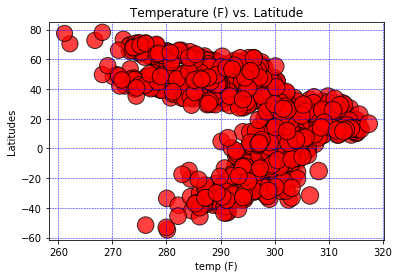

The code in analyzing the relation that temp & latitudes can have, it seems there is a positive correlation between them


In [58]:
temp = coordinates2["temp"].tolist()
Latitudes = coordinates2["Latitudes"].tolist()
Latitudes
plt.scatter(temp,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=temp)
plt.title("Temperature (F) vs. Latitude")
plt.xlabel("temp (F)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.show()
print("The code in analyzing the relation that temp & latitudes can have, it seems there is a positive correlation between them")

# Humidity (%) vs. Latitude

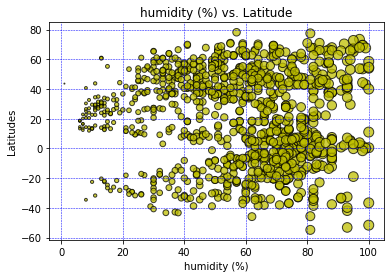

The code in analyzing the relation that humidity & latitudes can have, it seems there is a positive correlation between them


In [66]:
humidity = coordinates2["humidity"].tolist()
Latitudes = coordinates2["Latitudes"].tolist()
Latitudes
plt.scatter(humidity,Latitudes, marker="o", color="y", edgecolors="black", alpha = 0.75, s=humidity)
plt.title("humidity (%) vs. Latitude")
plt.xlabel("humidity (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.show()
print("The code in analyzing the relation that humidity & latitudes can have, it seems there is a positive correlation between them")

# Cloudiness (%) vs. Latitude

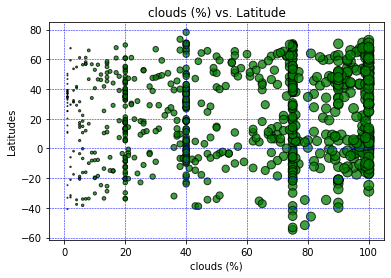

The code in analyzing the relation between the cloudiness and the latitude, it seems they do not really have a correlation


In [65]:
clouds = coordinates2["clouds"].tolist()
Latitudes = coordinates2["Latitudes"].tolist()
Latitudes
plt.scatter(clouds,Latitudes, marker="o", color="g", edgecolors="black", alpha = 0.75, s=clouds)
plt.title("clouds (%) vs. Latitude")
plt.xlabel("clouds (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.show()
print("The code in analyzing the relation between the cloudiness and the latitude, it seems they do not really have a correlation")

# Wind Speed (mph) vs. Latitude

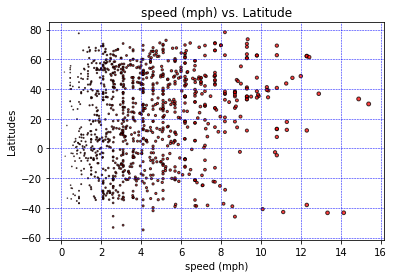

The code in analyzing the relation between wind speed and latitude, it seems that teh higher the latitude the faster the wond speed


In [67]:
speed = coordinates2["speed"].tolist()
Latitudes = coordinates2["Latitudes"].tolist()
Latitudes
plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("speed (mph) vs. Latitude")
plt.xlabel("speed (mph)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)
plt.show()
print("The code in analyzing the relation between wind speed and latitude, it seems that teh higher the latitude the faster the wond speed")

In [68]:
#Creando los data frames para poder hacer los calculos de cada hemisferio
south = coordinates2.loc[coordinates2['South'] == 'South']
north = coordinates2.loc[coordinates2['South'] == 'North']

# Northern Hemisphere 

In [69]:
north.head()

,city name,temp,humidity,speed,clouds,South,Longitudes,Latitudes
0,ponta do sol,293.70,53,2.10,20,North,-17.10,32.67
11,la asuncion,294.15,100,8.20,14,North,-63.86,11.03
13,ankara,290.62,23,1.50,20,North,32.85,39.92
14,svetlyy,286.15,58,6.00,93,North,20.13,54.67
15,dikson,272.03,97,9.34,38,North,80.55,73.51


Wind Speed (mph) vs. Latitude

R squared: 0.01074966971841979


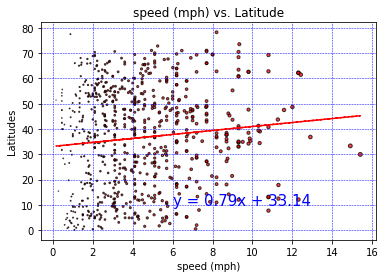

The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low


In [70]:
speed = north["speed"].tolist()
Latitudes = north["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("speed (mph) vs. Latitude")
plt.xlabel("speed (mph)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = north['speed'].astype('float')
y_values = north['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r--")
plt.annotate(line_eq,(6,10),fontsize=15,color="b")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

print("The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low")

Humidity (%) vs. Latitude

R squared: 0.0037393689907992017


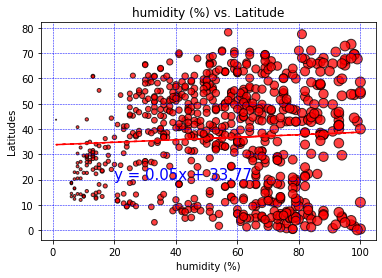

The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low and the graph points are very disperse


In [71]:
speed = north["humidity"].tolist()
Latitudes = north["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("humidity (%) vs. Latitude")
plt.xlabel("humidity (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = north['humidity'].astype('float')
y_values = north['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r--")
plt.annotate(line_eq,(20,20),fontsize=15,color="b")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low and the graph points are very disperse")

Cloudiness (%) vs. Latitude

R squared: 4.896599974459714e-05


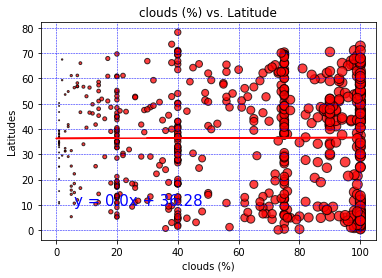

In [72]:
speed = north["clouds"].tolist()
Latitudes = north["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("clouds (%) vs. Latitude")
plt.xlabel("clouds (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = north['clouds'].astype('float')
y_values = north['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="b")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low")

Temperature (F) vs. Latitude

R squared: 0.5549033058829342


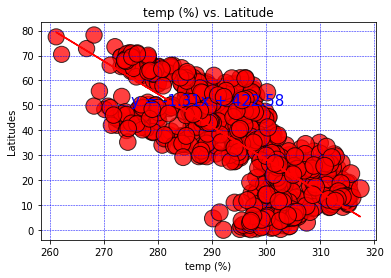

The code in analyzing the relation between the two variables, it seems that the regression i good as the r2 explains almost halfh of the points


In [73]:
speed = north["temp"].tolist()
Latitudes = north["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("temp (%) vs. Latitude")
plt.xlabel("temp (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = north['temp'].astype('float')
y_values = north['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(275,50),fontsize=15,color="b")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, it seems that the regression i good as the r2 explains almost halfh of the points")

# Souther Hemisphere 

In [22]:
south.head()

,city name,temp,humidity,speed,clouds,South,Longitudes,Latitudes
2,bredasdorp,288.15,93,1.50,86,South,20.04,-34.53
4,pitimbu,296.15,100,2.60,20,South,-34.81,-7.47
5,ushuaia,280.15,75,1.50,37,South,-68.3,-54.8
7,port alfred,288.15,98,3.12,1,South,26.89,-33.59
9,chala,288.15,87,2.60,20,South,31.27,-7.58


Temperature (F) vs. Latitude

R squared: 0.4994233841543908


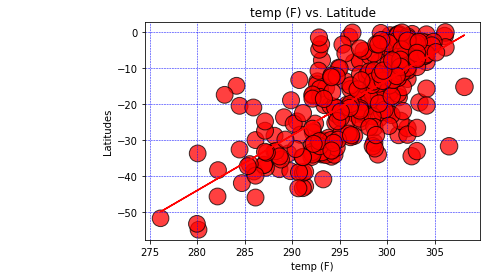

The code in analyzing the relation between the two variables, they have positive correlation but not high r2


In [74]:
speed = south["temp"].tolist()
Latitudes = south["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("temp (F) vs. Latitude")
plt.xlabel("temp (F)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = south['temp'].astype('float')
y_values = south['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(260,-25),fontsize=15,color="b")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, they have positive correlation but not high r2")

Humidity (%) vs. Latitude

R squared: 0.08317240679851817


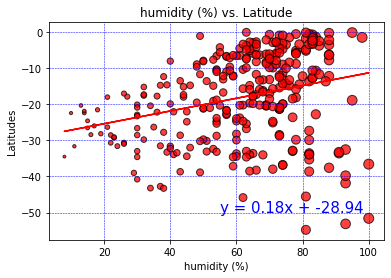

The code in analyzing the relation between the two variables, they regression is not very explicative


In [75]:
speed = south["humidity"].tolist()
Latitudes = south["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("humidity (%) vs. Latitude")
plt.xlabel("humidity (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = south['humidity'].astype('float')
y_values = south['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(55,-50),fontsize=15,color="b")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, they regression is not very explicative")

Cloudiness (%) vs. Latitude

R squared: 0.12731934931768496


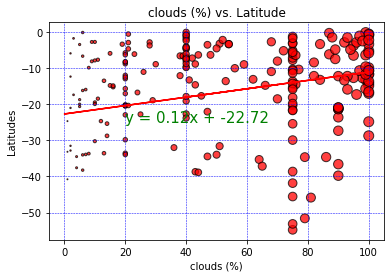

The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low


In [76]:
speed = south["clouds"].tolist()
Latitudes = south["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("clouds (%) vs. Latitude")
plt.xlabel("clouds (%)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = south['clouds'].astype('float')
y_values = south['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,-25),fontsize=15,color="g")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low")

Wind Speed (mph) vs. Latitude

R squared: 0.06253999621468653


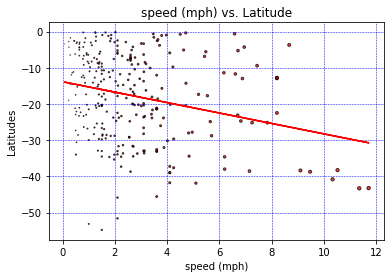

In [26]:
speed = south["speed"].tolist()
Latitudes = south["Latitudes"].tolist()

plt.scatter(speed,Latitudes, marker="o", color="r", edgecolors="black", alpha = 0.75, s=speed)
plt.title("speed (mph) vs. Latitude")
plt.xlabel("speed (mph)")
plt.ylabel("Latitudes")
plt.grid(color='b', linestyle='--', linewidth=0.5)

x_values = south['speed'].astype('float')
y_values = south['Latitudes'].astype('float')


# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(2,-60),fontsize=15,color="g")

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()
print("The code in analyzing the relation between the two variables, it seems that it is not very expicative as the r2 is very low")